# Automatic Differentiation with `torch.autograd`

When training neural networks, the most frequently used algorithm is **back propagation**. In this algorithm, parameters (model weights) are adjusted according to the **gradient** of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input x, parameters w and b, and some loss function. It can be defined in PyTorch in the following manner:

In [2]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## Tensors, Functions and Computational graph
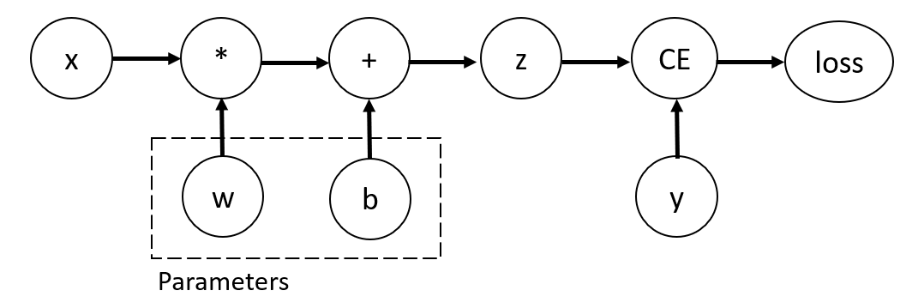


In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the requires_grad property of those tensors.


A function that we apply to tensors to construct computational graph is in fact an object of class Function. This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in grad_fn property of a tensor. You can find more information of Function in the documentation.



In [3]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x000001DB4EB70EB0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001DB4EB70550>


## Computing Gradients

To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need ∂loss/∂w and ∂loss/∂b under some fixed values of x and y. To compute those derivatives, we call loss.backward(), and then retrieve the values from w.grad and b.grad:

In [4]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3169, 0.0587, 0.3289],
        [0.3169, 0.0587, 0.3289],
        [0.3169, 0.0587, 0.3289],
        [0.3169, 0.0587, 0.3289],
        [0.3169, 0.0587, 0.3289]])
tensor([0.3169, 0.0587, 0.3289])


Note

* We can only obtain the grad properties for the leaf nodes of the computational graph, which have requires_grad property set to True. For all other nodes in our graph, gradients will not be available.

* We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.

## Disabling Gradient Tracking

By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with torch.no_grad() block:

In [5]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the detach() method on the tensor:

In [6]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:
To mark some parameters in your neural network as frozen parameters.

To speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

More on Computational Graphs
Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

* run the requested operation to compute a resulting tensor

* maintain the operation’s gradient function in the DAG.

The backward pass kicks off when .backward() is called on the DAG root. autograd then:

* computes the gradients from each .grad_fn,

* accumulates them in the respective tensor’s .grad attribute

* using the chain rule, propagates all the way to the leaf tensors.

Note

DAGs are dynamic in PyTorch An important thing to note is that the graph is recreated from scratch; after each .backward() call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed.